### Στοιχεία ομάδας (Ομάδα 1):

```
Neural Networks - Lab 3
Creators : 
Αναστάσης Αγγλογάλλος
Παναγιώτης Κοκκινάκης
Νικόλας Μπέλλος
```

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
import os

os.chdir("/content/gdrive/MyDrive/LAB-3 | Image_Captioning/")

!ls

 answer.txt				 test_cache
 BELLOS-Lab3-image_captioning.ipynb	 test_cache_features
 BELLOS-v2-Lab3-image_captioning.ipynb	 test_files.csv
 captions_new.csv			 test_test
 competition_files.csv			 train_cache
 image_dir				 train_cache_features
'image_dir (1)'				 train_files.csv
 Lab3-image_captioning.ipynb


In [4]:
# Confirm what GPU we are running on
!nvidia-smi -L
!lscpu |grep 'Model name'

GPU 0: Tesla T4 (UUID: GPU-c235744c-7ad6-b705-006c-b3a128665e0a)
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz


# Image captioning with visual attention

## Intro

**WHAT IS THIS NOTEBOOK ?**<BR>
This notebook is an end-to-end example. When you run the notebook, it downloads a dataset, extracts and caches the image features, and trains a decoder model. It then uses the model to generate captions on new images.

The model architecture used here is inspired by [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), but has been updated to use a 2-layer Transformer-decoder. To get the most out of this tutorial you should have some experience with [text generation](https://www.tensorflow.org/text/tutorials/text_generation),  [seq2seq models & attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention), or [transformers](https://www.tensorflow.org/text/tutorials/transformer).

The model architecture built in this tutorial is shown below. Features are extracted from the image, and passed to the cross-attention layers of the Transformer-decoder.
<table>
<tr>
  <th>The model architecture</th>
</tr>
<tr>
  <td>
   <img width=250 src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png"/>
  </td>
</tr>
</table>

The transformer decoder is mainly built from attention layers. It uses self-attention to process the sequence being generated, and it uses cross-attention to attend to the image.

By inspecting the attention weights of the cross attention layers you will see what parts of the image the model is looking at as it generates words.
<details>
<summary><b>Example</b></summary>

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

</details>

## Setup

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
!pip uninstall -y tensorflow estimator keras

In [ ]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

In [ ]:
!pip install einops

In [9]:
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

### Choose a dataset

This tutorial is set up to give a choice of datasets. Either [Flickr8k](https://www.ijcai.org/Proceedings/15/Papers/593.pdf) or a small slice of the [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) dataset. These two are downloaded and converted from scratch, but it wouldn't be hard to convert the tutorial to use the caption datasets available in [TensorFlow Datasets](https://www.tensorflow.org/datasets): [Coco Captions](https://www.tensorflow.org/datasets/catalog/coco_captions) and the full [Conceptual Captions](https://www.tensorflow.org/datasets/community_catalog/huggingface/conceptual_captions).

Εμείς κατεβάζουμε το flickr30k-images-ecemod το οποίο περιέχει :     
  
*   ένας φάκελος "image_dir" με 31.783 εικόνες από το Flickr
*   ένα αρχείο "captions_new.csv" με 148.915 captions για τις εικόνες του "image_dir"

*   ένα αρχείο "train_files.csv" λίστα των 21.000 εικόνων που αποτελούν το training set
*   ένα αρχείο "test_files.csv" λίστα των 4.524 εικόνων που αποτελούν το test set




  


#### Download the dataset (DEPRICATED)

In [ ]:
# Download with keras: https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file
# Download image files
# image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
#                                     cache_subdir=os.path.abspath('.'),
#                                     origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
#                                     extract=True)
# os.remove(image_zip)

In [ ]:
# Download captions file
# (Κάθε caption έχει τρία πεδία, το όνομα του αρχείου της εικόνας, τον αύξοντα αριθμό του caption και τέλος το ίδιο το caption.)
# captions_file = tf.keras.utils.get_file('captions_new.csv',
#                                         cache_subdir=os.path.abspath('.'),
#                                         origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',
#                                         extract=False)

# # Download train files list
# # (list of image file names)
# train_files_list = tf.keras.utils.get_file('train_files.csv',
#                                            cache_subdir=os.path.abspath('.'),
#                                            origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',
#                                            extract=False)

# # Download test files list
# # (list of image file names)
# test_files_list = tf.keras.utils.get_file('test_files.csv',
#                                           cache_subdir=os.path.abspath('.'),
#                                           origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',
#                                           extract=False)

#### Import the dataset locally (Alternative)

In [10]:
# CAPTIONS FILE (path)
captions_file_path = tf.keras.utils.get_file('captions_new.csv',
                                        cache_subdir=os.path.abspath('.'),
                                        origin='/captions_new.csv',
                                        extract=False)
# TRAIN SET FILE (path)
train_files_path = tf.keras.utils.get_file('train_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='/train_files.csv',
                                           extract=False)
# TEST SET FILE (path)
test_files_path = tf.keras.utils.get_file('test_files.csv',
                                          cache_subdir=os.path.abspath('.'),
                                          origin='/test_files.csv',
                                          extract=False)


### Parse the dataset

In [11]:
path="."
IMAGE_DIR="image_dir"
path = pathlib.Path(path)
   
# READ CAPTIONS
captions = (path/captions_file_path).read_text().splitlines() # [image-0#0 \t caption-0, image-0#1 \t caption-1, ..., image-N#0 \t caption-0,]
captions = (line.split('\t') for line in captions)  # [(image-0#0, caption-0), (image-0#1, caption-1), ..., (image-N#0, caption-0)]
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions) # [(image-0, caption-0), (image-0, caption-1), ..., (image-N, caption-0)]
   
# CREATE DICTIONARY OF (image, captions) PAIRS
cap_dict = collections.defaultdict(list) # Dictionary of list (key: image file name, value: list of captions for same image)
for fname, cap in captions:
  cap_dict[fname].append(cap)

# READ TRAIN FILES
train_files = (path/train_files_path).read_text().splitlines()
train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files] # list of tuples. Tuple: (image file path, [caption1, caption2, ..])
   
# READ TEST FILES
test_files = (path/test_files_path).read_text().splitlines()
test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files] # list of tuples. Tuple: (image file path, [caption1, caption2, ..])
   
# CREATE DATASETS (TRAIN, TEST)
train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

In [ ]:
train_raw.element_spec # Type of Dataset elements

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [ ]:
# DATASET SNEAK PEAK
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'image_dir/_3430497.jpg', shape=(), dtype=string)
tf.Tensor(
[b'The skier is wearing a yellow jumpsuit and sliding across a yellow rail .'
 b'A yellow uniformed skier is performing a trick across a railed object .'
 b'A skier in electric green on the edge of a ramp made of metal bars .'
 b'A person on skis on a rail at night .'
 b'A skier slides along a metal rail .'], shape=(5,), dtype=string)


### Image feature extractor

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  


In [12]:
IMAGE_SHAPE=(224, 224, 3)

# Feature Extractor used in Tutorial
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False, # Exclude final classification layer
    include_preprocessing=True
)

# Feature Extractor 
xception = tf.keras.applications.Xception(
   input_shape=IMAGE_SHAPE,
   include_top=False, # Exclude final classification layer
   #Error code from -> include_preprocessing=True
)

mobilenet.trainable=False

83683744/83683744 [==============================] - 4s 0us/step


Here's a function to load an image and resize it for the model:

In [13]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

The model returns a feature map for each image in the input batch:

In [ ]:
print(ex_path)

test_img_batch = load_image(ex_path)[tf.newaxis, :] # adds new axis at the front

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

tf.Tensor(b'image_dir/_3430497.jpg', shape=(), dtype=string)
(1, 224, 224, 3)
(1, 7, 7, 576)


### Setup the text tokenizer/vectorizer

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

#### !Text Preproccesing

In [14]:
synonyms_list = [
    ('several', 'many'),
    ('quick', 'fast'),
    ('large', 'big'),
]
numbers_list = ['four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen']

In [15]:
# Reference: https://www.tensorflow.org/text/guide/word_embeddings#:~:text=good%20next%20step.-,Text%20preprocessing,-Next%2C%20define%20the
def standardize(s):
  s = tf.strings.lower(s)
  # Remove punctuation
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '') # add escape characters
  # Avoid Stemming, Removing stop words : For captions to look natural we need stem words in our model training data
  # Replace synonyms, verbal numbers, abreviations
  for synonym in synonyms_list:
    s = tf.strings.regex_replace(s, fr'\b{synonym[0]}\b', synonym[1]) # \b declares the synonym should match the whole word
  for number in numbers_list:
    s = tf.strings.regex_replace(s, fr'\b{number}\b', '')
  # Remove whitespaces : the tokenizer removes whitespaces automatically when converting words to integers
  s = tf.strings.strip(s)
  s = tf.strings.reduce_join(tf.strings.split(s), separator=' ', axis=-1)
  # Add start, end words to caption
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ') 
  return s

In [ ]:
standardize('this is a cat with several legs')

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] this is a cat with many legs [END]'>

In [16]:
# Use the top X (ex.5000) words for a vocabulary.
# Alternatives: 1000, 5000, 2000, 80000, 15000, MAX: 16803
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True
)
# Learn the vocabulary from the caption data.

In [17]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'and', 'man']

In [ ]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 750, 5, 2, 63, 4], [3, 2, 2857, 34, 4]]>

In [18]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [ ]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### Prepare the datasets

The `train_raw` and `test_raw` datasets contain 1:many `(image, captions)` pairs. 

This function will replicate the image so there are 1:1 images to captions:

#### Replicate images for 1:1 representation

In [19]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [ ]:
# EXAMPLE for replicating 1 batch of photos in the train dataset
for ex_paths, ex_captions in train_raw.batch(32).take(1): # batch(32) takes sets of 32 photos each
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


What do `prepare_images` and `prepare_text` do:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

#### Extract image features

In [20]:
def prepare_images(ds, image_model, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)                                         # How .shuffle works: https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset#:~:text=dataset.shuffle(buffer_size%3D3,connected%20to%20the%20source%20dataset.
        .map(lambda path, caption: (load_image(path), caption)) # Resize images
        .apply(tf.data.experimental.ignore_errors())            # Ignore missing images
        .batch(batch_size)                                      # Partition data into batches
        .map(lambda images, captions: (image_model(images), captions)) # Get feature maps of images
        .map(match_shapes, tf.data.AUTOTUNE)                    # Replicate images for 1:1 representation
        .unbatch()
        .shuffle(shuffle_buffer)
  )
  return ds

#### Tokenize text + add padding

To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [21]:
def prepare_tokens(imgs, txts):
  tokens = tokenizer(txts)

  # INITIAL PHRASE
  input_tokens = tokens[..., :-1]
  print(input_tokens)
  # OUTPUT PHRASE
  label_tokens = tokens[..., 1:]
  print(label_tokens)
  return (imgs, input_tokens), label_tokens # TRAIN THE MODEL BASED ON label_tokens

In [22]:
def prepare_text(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor() # Convert RaggedTensor to Tensor

  ds = (ds
        # .batch(1000)
        .map(prepare_tokens, tf.data.AUTOTUNE)   # Prepare input_tokens, label_tokens
        # .map(to_tensor, tf.data.AUTOTUNE)     # Add padding to embeddings
        # .unbatch()
        .shuffle(shuffle_buffer)
        .padded_batch(batch_size)             # Add padding to embeddings
  )
  return ds

### Cache the image features

In [ ]:
def save_dataset(ds, save_path, shards=10):
  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  ds.enumerate().save(save_path, shard_func=shard_func)

In [23]:
def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        # .shuffle(shuffle)
        .prefetch(tf.data.AUTOTUNE)   # Prepare later elements, while the current is being processed. Improves latency, throughput.
  )  
  
  return ds

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions `save_dataset` and `load_dataset`: 

In [ ]:
# ds_images_train = prepare_images(train_raw, mobilenet)
# ds_images_test = prepare_images(test_raw, mobilenet)

In [ ]:
# save_dataset(ds_images_train, 'train_cache_features') # Saves (image features, captions) ex. ds -> (image_1_features, caption_1), (image_1_features, caption_2), ...
# save_dataset(ds_images_test, 'test_cache_features')

 </section>


## Data ready for training

After those preprocessing steps, here are the datasets:

In [24]:
train_ds_features = load_dataset('train_cache_features')
test_ds_features = load_dataset('test_cache_features')

In [25]:
# Get the tokenized captions
train_ds = prepare_text(train_ds_features, tokenizer) # ((image_features, input_tokens), output_tokens)
test_ds = prepare_text(test_ds_features, tokenizer)

Tensor("strided_slice:0", shape=(None,), dtype=int64)
Tensor("strided_slice_1:0", shape=(None,), dtype=int64)
Tensor("strided_slice:0", shape=(None,), dtype=int64)
Tensor("strided_slice_1:0", shape=(None,), dtype=int64)


In [ ]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [ ]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 26)
(32, 26)


The input tokens and the labels are the same, just shifted by 1 step:

In [ ]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   3    2  610 1948    1  110   10  294  149   38    7    6  492    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
[   2  610 1948    1  110   10  294  149   38    7    6  492    4    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


## A Transformer decoder model

This model assumes that the pretrained image encoder is sufficient, and just focuses on building the text decoder. This tutorial uses a 2-layer Transformer-decoder.

The implementations are almost identical to those in the [Transformers tutorial](https://www.tensorflow.org/text/tutorials/transformer). Refer back to it for more details.

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=250 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts: 

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs. 

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.

#### !Pretrained GloVe-wiki embeddings

Τώρα θα χρησιμοποιήσουμε pretrained glove-wiki embeddings, καθώς μπορούμε να επωφεληθούμε από το γεγονός ότι έχουν προκύψει ύστερα από εκπαίδευση σε πολύ μεγάλα σύνολα δεδομένων και από το γεγονός ότι μπορούμε να εξοικονομήσουμε χρόνο εκπαίδευσης, αφού αυτό το επίπεδο δεν θα απαιτεί πλέον εκπαίδευση.

Με την χρήση των προεκπαιδευμένων μοντέλων embeddings μπορούμε να παρατηρήσουμε μια μικρή βελτίωση της απόδοσης του μοντέλου και μια σημαντική μείωση του χρόνου εκπαίδευσης.

In [26]:
import gensim.downloader 

#Όλα τα διαθέσιμα pretrained μοντέλα που μπορούμε να χρησιμοοποιήσουμε
for i in list(gensim.downloader.info()['models'].keys()):
    print(i)

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [27]:
# Διαλέξτε ένα απο τα παρακάτω embeddings

#glove_wiki_50 = gensim.downloader.load('glove-wiki-gigaword-50')
#glove_wiki_100 = gensim.downloader.load('glove-wiki-gigaword-100')
# glove_wiki_200 = gensim.downloader.load('glove-wiki-gigaword-200')
glove_wiki_300 = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [28]:
# Ανάλογα με την επιλογή μας αλλάζουμε τις παρακάτω παραμέτρους 
embed_model = glove_wiki_300
EMBEDDING_DIM = 300

Ο πίνακας embedding_matrix μας παρέχει μια αντιστοιχία 1-1 μεταξύ μιας λέξης και της ενσωμάτωσής της. Για τις λέξεις που δεν περιλαμβάνονται στο μοντέλο (glove-wiki-x), οι οποίες πρέπει να είναι λίγες, τις αντιστοιχίζουμε σε μηδενικό διάνυσμα.

In [39]:
VOCABULARY_SIZE = tokenizer.vocabulary_size() # = 5000
# Αρχικοποιούμε το πίνακά μας στις διαστάσεις του μοντέλου
embedding_matrix = np.zeros((VOCABULARY_SIZE, EMBEDDING_DIM))
 
for idx, word in enumerate(tokenizer.get_vocabulary()):
    try:
        embedding_vector = embed_model[word]
        embedding_matrix[idx] = embedding_vector
    except KeyError:
        vec = np.zeros(EMBEDDING_DIM)
        embedding_matrix[idx] = vec

In [ ]:
embedding_matrix.shape

(5000, 300)

In [29]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
     # Depth = Embedding Dimension Output = Units
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        weights=[embedding_matrix], #Χρησιμοποιούμε τα έτοιμα βάρη
        trainable=False)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

In [30]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [31]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [32]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [33]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`, 
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well. 

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [34]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [35]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels)) # Create a vocabulary from the existing captions

100%|██████████| 1784/1784 [01:08<00:00, 26.11it/s]


Uniform entropy: 8.52
Marginal entropy: 5.46


### Build the model

#### Captioner Class

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to 
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [36]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1): # max_length = 100
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units, # = Embedding_Dimension_Output
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


In [37]:
@Captioner.add_method
def call(self, inputs):
  image, txt = inputs

  if image.shape[-1] == 3:
    # Apply the feature-extractor, if you get an RGB image.
    image = self.feature_extractor(image)
  
  # Flatten the feature map
  image = einops.rearrange(image, 'b h w c -> b (h w) c')


  if txt.dtype == tf.string:
    # Apply the tokenizer if you get string inputs.
    txt = tokenizer(txt)

  txt = self.seq_embedding(txt)

  # Look at the image
  for dec_layer in self.decoder_layers:
    txt = dec_layer(inputs=(image, txt))
    
  txt = self.output_layer(txt)

  return txt

#### !Υπερπαράμετροι του Decoder
Παρατηρούμε αύξηση του corpus_bleu score όσο αυξάνουμε των αριθμό των layers και heads, όπως είναι αναμενόμενο, όμως με αυτόν τον τρόπο αυξάνεται η πολυπλοκότητα του μοντέλου, συνεπώς και ο χρονος εκπαίδευσης του. 
Στη μεταβλητή units θέτουμε την τιμή 300, δηλαδή την τιμή διάστασης του μοντέλου που επιλέξαμε για τα Embeddings. Και πάλι όπως είναι αναμενόμενο, με μεγαλύτερη διάσταση μοντέλου Embeddings έχουμε καλύτερα αποτελέσματα. Τέλος το dropout rate βγάζει βέλτιστα αποτελέσματα σε τιμές κοντά στο 0.5.

In [40]:
# Θέτουμε την μεταβλητή units ανάλογα με τη διάσταση του μοντέλου που διαλέξαμε (Embedding_Dimension)
model = Captioner(
    tokenizer, 
    feature_extractor=mobilenet, 
    output_layer=output_layer, 
    units=EMBEDDING_DIM, 
    dropout_rate=0.5, 
    num_layers=8, 
    num_heads=10
)

### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [41]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

64400/64400 [==============================] - 0s 2us/step


#### !Beam Search generation

The Beam Search parameter b determines how many branches / sentences we choose in each stem of the sentence generation process. <br>
Usually, the bigger the parameter b the better the accuracy of the model, but the longer it takes for the captions generation.
Usually, a parameter b=5 is a good tradeoff between time and performance. <br>
Here we use a default value of b=2 in order to speed up the process of finding the best hyperparameters. <br> 
(The value b=3 gives us equally good results with value b=5, so we choose that)

The **temperature** parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`). 

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

In [42]:
@Captioner.add_method
def simple_gen(self, image, beam_search=True, beam_size=2, temperature=1):

  initial = self.word_to_index([['[START]']])                        # 'START' token == 3
  if image.shape[-1] == 3:
    img_features = self.feature_extractor(image[tf.newaxis, ...])    # extract features from image
  else:
    img_features = image[tf.newaxis, :]

  def beam_search_gen():
    tokens_list = [(initial, 0.0)]                  # list of tuples (tokens, propability): stores the top b sentences for each branch (in each iteration)
    final_tokens_list = []                          # list of tuples (tokens, propability): final top b selected sentences

    remaining_beam_size = beam_size                 # Counter for how many branches in the beam search tree have not terminated yet
    for n in range(50):
      if remaining_beam_size == 0:
        break
      new_tokens_list = []                          # top_b tokens for each branch (b*b tokens)
      for tokens, prob in tokens_list:              # tokens: [3, 15, 22, 10, ...], prob: float (ex. 0.23)
        if tokens[0][-1] == self.word_to_index('[END]') or n == 49:
          remaining_beam_size -= 1
          final_tokens_list.append((tokens, prob))
          continue
        preds = self((img_features, tokens)).numpy()    # generate probabilities for all words given a sentence 'tokens' and an image 'img_features'
        preds = preds[:, -1, :]                         # get the probabilities vector only for the last word
        top_b_preds = tf.math.top_k(preds, k=remaining_beam_size) # get the b words with the biggest probability
        top_b_tokens = top_b_preds.indices              # tokens 
        top_b_prob = top_b_preds.values                 # probabilities
        for i in range(remaining_beam_size):
          next_token = [[top_b_tokens[0][i]]]           # next token to be added to the sentence (in one branch)
          new_tokens = tf.concat([tokens, next_token], axis=1)
          new_log_prob = prob + top_b_prob[0][i]
          new_tokens_list.append((new_tokens, new_log_prob))
        
      tokens_list = sorted(new_tokens_list, key=lambda x: -x[1])[:remaining_beam_size] # Sort the list with b*b sentences and keep the first b

    # Return the sentence with the biggest (probability / sentence length) score
    # print(final_tokens_list)
    tokens, prob = max(final_tokens_list, key=lambda x: x[1]/len(x[0][0, 1:-1]))
    words = index_to_word(tokens[0, 1:-1])
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    return result.numpy().decode()
  
  # ============================================================================
  def temperature_gen():
    tokens = initial # (batch, sequence)
    for n in range(50):
      # 1. Get predictions given the previous words and the features
      preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab) -> shape (1, sentence length , list of values for each word)
      # print(preds.shape) # -> ex. (1, 4, 5000)
      # 2. Get the last generated vector
      preds = preds[:,-1, :]  #(batch, vocab) -> take the last vector from the sentence
      # print(preds.shape) # -> ex. (1, 5000)
      # 3. Choose the next word based on the temperature parameter
      if temperature==0:
          next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
      else:
          next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
      # 4. Add the selected word to the sentence
      tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

      if next[0] == self.word_to_index('[END]'):
        break
    words = index_to_word(tokens[0, 1:-1])
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    return result.numpy().decode()

  if (beam_search):
    return beam_search_gen()
  else:
    return temperature_gen()

Here are some generated captions for that image, the model's untrained, so they don't make much sense yet:

In [ ]:
model.simple_gen(image, beam_size=3)

'a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a'

In [ ]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, False, temperature=t)
  print(type(result))
  print(result)

<class 'str'>
a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
<class 'str'>
a a a a a a a through playing a a a a a a a a man a a a a woman a a a a
<class 'str'>
a team motorcycle in pants of many hanging dusk man bright girls in grass


## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Prepare datasets for metrics / validation

In [43]:
# TRAIN SET: (image_path, [caption 1, caption 2, ...]) -> (image, [caption 1, caption 2, ...])
train_raw_filtered = (train_raw
        .map(lambda path, caption: (load_image(path), caption)) # Resize images
        .apply(tf.data.experimental.ignore_errors())            # Ignore missing images
)
# TEST SET: (image_path, [caption 1, caption 2, ...]) -> (image, [caption 1, caption 2, ...])
test_raw_filtered = (test_raw
        .map(lambda path, caption: (load_image(path), caption)) # Resize images
        .apply(tf.data.experimental.ignore_errors())            # Ignore missing images
)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


### Losses and metrics

In [44]:
import nltk.translate.bleu_score as bleu_score
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [45]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

#### !Bleu Score

Υλοποιούμε 3 συναρτήσεις για την αξιολόγηση του μοντέλου μας μέσω της BLEU metric.

Η **sentence_bleu_score** λαμβάνει ως ορίσματα τις ετικέτες του dataset και τις προβλεπόμενες ετικέτες απο το μοντέλο και επιστρέφει το bleu score για την εικόνα με τα labels αυτά.

Η **evaluate_bleu** λαμβάνει ως όρισμα ένα index της εικόνας στο Test Dataset, την οποία θέλουμε να αξιολογήσουμε, και υπολογίζει το bleu score της χρησιμοποιώντας την συνάρτηση sentence_bleu.

Η **batch_bleu** λαμβάνει ως όρισμα το μέγεθος του batch από εικόνες του Dataset το οποίο θέλουμε να αξιολογήσουμε και χρησιμοποιώντας την corpus_bleu επιστρέφει το bleu score του batch.

In [46]:
def sentence_bleu_score(labels, preds):
  weights = (0.4, 0.3, 0.2, 0.1)
  smoothing_function=SmoothingFunction().method1
  # labels: Tensor(['caption 1', 'caption 2', 'caption 3', ...])
  labels = labels.numpy().tolist()                                    # Cast tensor to list
  labels = [item[:-1].decode().lower().split() for item in labels]    # Split sentence into list of words + remove . from end
  preds = preds.split()                                               # Turn predictions into list of words
  print(labels)
  print(preds)

  bleu_score = sentence_bleu(
      labels,
      preds,
      weights = weights, 
      smoothing_function = smoothing_function
  )
  return bleu_score
  

In [ ]:
for ex_image, ex_captions in train_raw_filtered.take(1):
  ex_output = model.simple_gen(ex_image)
  bleu = sentence_bleu_score(ex_captions, ex_output)
  print(bleu)

[['the', 'skier', 'is', 'wearing', 'a', 'yellow', 'jumpsuit', 'and', 'sliding', 'across', 'a', 'yellow', 'rail'], ['a', 'yellow', 'uniformed', 'skier', 'is', 'performing', 'a', 'trick', 'across', 'a', 'railed', 'object'], ['a', 'skier', 'in', 'electric', 'green', 'on', 'the', 'edge', 'of', 'a', 'ramp', 'made', 'of', 'metal', 'bars'], ['a', 'person', 'on', 'skis', 'on', 'a', 'rail', 'at', 'night'], ['a', 'skier', 'slides', 'along', 'a', 'metal', 'rail']]
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
0.008295638755017072


In [47]:
def evaluate_bleu(input):
  iterator = iter(test_raw_filtered)
  for nr in range(input):
    test_raw_instance = iterator.get_next()

  img, labels = test_raw_instance
  result = model.simple_gen(img, beam_size=2, temperature=0.0) # to use temperature metric : simple_gen(img, False, temperature=0)

  labels = str(tf.strings.reduce_join(labels.numpy().tolist(), separator=' ', axis=-1).numpy())
  labels = labels.split('.')
  labels = [item.lower().split() for item in labels[:-1]]
  print()
  print(labels)
  preds = result.split()
  print()
  print(preds)

  weights = (0.4, 0.3, 0.2, 0.1)
  smoothing_function=SmoothingFunction().method1
  bleu = sentence_bleu(labels, preds, weights = weights, smoothing_function = smoothing_function)

  return bleu

In [ ]:
# evaluate_bleu(6)


[["b'one", 'man', 'lays', 'down', 'on', 'a', 'lawn', 'table', 'in', 'the', 'background', 'while', 'an', 'older', 'lady', 'stands', ',', 'looking', 'down', 'in', 'the', 'foreground', 'a', 'man', 'is', 'passed', 'out', 'asleep', 'on', 'a', 'patio', 'table', 'while', 'his', 'mother', 'looks', 'down', 'at', 'the', 'ground'], ['a', 'man', 'in', 'black', 'is', 'sitting', 'at', 'a', 'table', 'taking', 'a', 'photo', 'of', 'an', 'older', 'woman', 'on', 'a', 'patio'], ['an', 'older', 'lady', 'walking', 'by', 'a', 'man', 'who', 'is', 'laying', 'on', 'the', 'table', 'looking', 'at', 'something'], ['a', 'younger', 'man', 'takes', 'a', 'picture', 'of', 'what', 'an', 'older', 'women', 'stands', 'over']]

['a', 'man', 'in', 'a', 'black', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'building']


0.19696803427432394

In [58]:
def batch_bleu(batch_size):
  labels_list = []
  preds_list = []
  for images, labels in test_raw_filtered.batch(batch_size).take(1):
    break

  for image in images:
    result = model.simple_gen(image, temperature=0.0)
    preds = result.split()
    preds_list.append(preds)

  for label in labels:    
    label = label.numpy().tolist()                                    # Cast tensor to list
    label = [item[:-1].decode().lower().split() for item in label]    # Split sentence into list of words + remove . from end
    labels_list.append(label)

  weights = (0.4, 0.3, 0.2, 0.1)
  smoothing_function=SmoothingFunction().method1
  bleu = corpus_bleu(labels_list, preds_list, weights = weights, smoothing_function = smoothing_function)
  # print(bleu)

  return bleu

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [49]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, False,temperature=t)
      print(result)
    # beam_res = self.model.simple_gen(self.image, beam_size=3)
    # print(result)
    print()


It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [ ]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)





on surrounded in its sharp hill sleeping sitting on to another past carrying soldiers a woman



Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [50]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True
    )
]

### Train

Configure and execute the training.

In [51]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=masked_loss,    # Model goal is to minimize the loss
    metrics=[masked_acc] 
)

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`. 

With this setup on `Flickr8k` a full pass over the dataset is 900+ batches, but below the reporting-epochs are 100 steps.

In [52]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.2720 - masked_acc: 0.1681

a man in a man in a man in a man
a man in a man on a man in a man in a blue
a man in the washing in brown speak in a red

100/100 [==============================] - 100s 505ms/step - loss: 5.2720 - masked_acc: 0.1681 - val_loss: 4.9213 - val_masked_acc: 0.2221
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.8497 - masked_acc: 0.2307

a man in a man in a white and a white and a white and a white and a white and a white and a man is is is is is is is is is is is is is is is is is is is in a white and
a man in a man in a white and a blue blue child in a man is man on a ball
a 2 a snowboarder wearing a have men is catch surrounded up the rocks into the stunt

100/100 [==============================] - 48s 478ms/step - loss: 4.8497 - masked_acc: 0.2307 - val_loss: 4.6523 - val_masked_acc: 0.2508
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.

Plot the loss and accuracy over the training run:

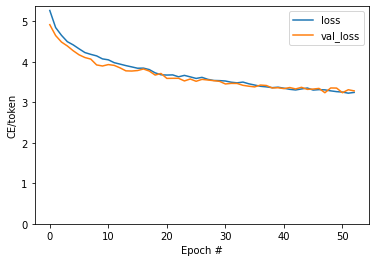

In [53]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

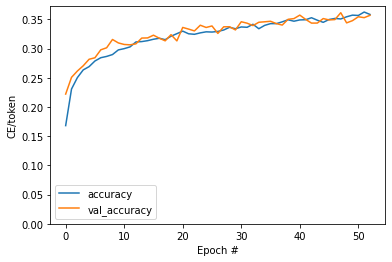

In [54]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Save & Load Model

## Evaluate model with Test Dataset (corpus bleu metric)

In [56]:
# Reference: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb
# Save Captioner model
model.save('saved_model') 

In [ ]:
# Load Captioner model
test_model = tf.keras.models.load_model('saved_model')
# Check its architecture
test_model.summary()

#### !Bleu score for 100 images

In [60]:
start_time = time.time()
bleu_score = batch_bleu(100)
print("Corpus BLEU Score for 100 images: ", bleu_score)
print("Execution time(s) :",  time.time() - start_time)

Corpus BLEU Score for 100 images:  0.26848491134788727
Execution time(s) : 693.240877866745


#### !Bleu score for 1000 images

In [61]:
bleu_score = batch_bleu(1000)
print("Corpus BLEU Score for 1000 images: ", bleu_score)

Corpus BLEU Score for 1000 images:  0.26307498313067007


#### Parameters chosen (table)

    Optimization    | Parameter          Justification
    ----------------------------------------------
    Encoder         | mobilenet          Produced better results over the xception encoder (also was a bit faster)
    ---
    Embeddings      | glove_wiki_300     Pretrained embeddings produced slightly better bleu score than our own generated embeddings (also the training process was faster)
    ---
    Beam Search     | beam size = 3      Smaller beam size gave less accurate results, while bigger sizes gave same accuracy but required more training time
    ---
    Decoder         | dropout rate = 0.5
    Hyperparameters | units = 300        (οσο το μεγεθος των embeddings)
                    | num_layers=8       More layers lead to better accuracy. However, the bigger the layers size the more time consuming is the model tranining. 8 decoder layers is a sweet spot for our training.
                    | num_heads=10

## Prepare dataset for mini-competition

In [ ]:
# COMPETITION SET FILE (path)
competition_files_path = tf.keras.utils.get_file('competition_files.csv',
                                          cache_subdir=os.path.abspath('.'),
                                          origin='/competition_files.csv',
                                          extract=False)

In [ ]:
# READ COMPETITION FILES
competition_files = (path/competition_files_path).read_text().splitlines()
competition_files = [str(path/IMAGE_DIR/fname) for fname in competition_files]
# CREATE DATASETS
competition_raw = tf.data.experimental.from_list(competition_files)
competition_raw.element_spec # Type of Dataset elements

TensorSpec(shape=(), dtype=tf.string, name=None)

In [ ]:
# LOAD IMAGES
competition_ds = (competition_raw
        .map(lambda path: (load_image(path)))             # Resize images
        .apply(tf.data.experimental.ignore_errors())      # Ignore missing images
)

In [ ]:
# Generate predictions
competition_predictions = []              # List with predictions for all images
for image in competition_ds.take(1):
  output = model.simple_gen(image)        # Caption prediction for 1 photo
  output = output.split()
  competition_predictions.append(output)

print(competition_predictions)

In [ ]:
# Convert to JSON
jsonString = json.dumps(competition_predictions)
jsonFile = open("test_hypotheses.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

In [ ]:
# Surfer image
result = model.simple_gen(image, temperature=0.0)
result

Split the output back into tokens:

In [ ]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [ ]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [ ]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean'
)

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [ ]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

So here is where the model was focusing attention while generating each token of the output:

In [ ]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

In [ ]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Now put that together into a more usable function:

In [ ]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


In [ ]:
run_and_show_attention(model, image)

### Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for strange results!)


In [ ]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)